# <strong> Human Activity Recognition </strong>

*Names: <br>
Mariah Sabioni <br>
Jitse van Esch <br>*

In this assignment we use a dataset containing acceleration and gyroscope data from phone users to predict certain activities in real time.  <br>

The dataset used can be found in [1]. It contains samples of measurements with their correspondent labels.

## <strong> <em> Introduction </em> </strong>

Human activity recognition is the problem of classifying sequences of accelerometer (and possibly gyroscope) data recorded by sensors into known well-defined movements [2].

Different approaches have been used to address this kind of problem, with several successful examples using techniques like linear regression, SVM and Decision Trees. Recently, deep learning methods such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs) have been shown to provide very good results.

The KU-HAR dataset has been recently published and provides several samples of labeled data for HAR tasks. Two studies were found using the same dataset, both with different machine learning techniques. The first used a Random Forest model and got an accuracy score of 90% [3]. The second uses both 1D CNNs and 2D CNNs, obtaining 89% and 97% accuracy scores, respectively [4].

We propose a 1D CNN model to predict the acitivity based on 3s of data. This allows for near-real time prediction. The evaluation was carried out based on accuracy score for the test dataset. The confusion matrix was also analysed to identify where the model performs worse.

Based on the results, we found that our 1D convolution neural network provides 93% accuracy when trained and tested with 3s of data. We believe that this is a good result given the performance observed in the previous studies.

## <em> Imports </em>

In [1]:
#General
import numpy as np
import pandas as pd
import datetime as dt
import os
import pickle

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit
import sklearn as sk
from sklearn import metrics
from sklearn import model_selection as ms
from sklearn import utils

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as kl

## <em> Data Loading </em>

Firstly, the raw data from the dataset is loaded to a dataframe. We choose to use folder 3 "Time_domain_subsamples.zip", since it contais pre-processed samples of data. The samples consist of 3 seconds of non-overlapping data, sampled at 100Hz. The data is organized in 20750 rows, so that each row contains the data of a different sample.

The dictionary that assigns the content of each column (available at [1]) uses column indexes from 1 to 1803 to describe the columns. Therefore, we name the columns of our dataframe the same way.

The result is a dataframe with the raw data from the .csv, where the columns are named after their indices.

In [2]:
#Settings
#foldername = "./data/3.Time_domain_subsamples/"
filename = "KU-HAR_time_domain_subsamples_20750x300.csv"

In [3]:
#Loading into dataframe
#df = pd.read_csv(os.path.join(foldername,filename))
df = pd.read_csv(filename)

#Apply column names from dataset description to dataframe
df.columns = list(range(1,df.shape[1]+1)) 

In [4]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803
0,0.012482,0.032496,0.067856,0.071552,0.078103,0.040353,-0.001059,-0.018580,-0.026813,-0.011280,...,-0.008210,-0.010408,-0.011459,-0.011747,-0.010394,-0.008070,-0.004354,0,300,2
1,0.012127,0.028458,0.062075,0.052611,0.022942,-0.010017,-0.023151,-0.028515,0.005036,0.008450,...,0.000915,0.000771,-0.002560,-0.003020,-0.004190,0.000215,0.000850,0,300,3
2,0.052964,0.074319,0.110670,0.108490,0.091825,0.056989,0.029337,-0.016724,-0.042265,-0.053983,...,-0.001209,0.002878,0.000663,0.000982,-0.002148,-0.009200,-0.010653,0,300,4
3,-0.020462,-0.030787,-0.008617,0.008906,0.045046,0.042136,0.045037,0.045182,0.025113,0.021730,...,-0.006369,-0.006614,-0.004698,-0.007279,-0.006861,-0.006161,-0.006113,0,300,5
4,0.039138,0.037687,0.022782,0.009661,-0.000885,-0.000630,-0.019837,-0.016246,-0.007580,0.001479,...,0.001930,0.004500,0.008865,0.011290,0.010965,0.010364,0.009872,0,300,6


## <em> Data Transformation </em>

To feed the CNN model, we need to transform the dataframe above into arrays of data that can be interpreted as features, or our model predictors. We want to have 6 predictors: 3 dimensions of acceleration data and 3 dimensions of gyroscope data.

Therefore, we create an array for each of the predictors, containing 20749 subsamples with 300 points of data each.

Since we want our model to learn from the 6 predictors at the same time, we then append them to a single array named "feature_array". 

Similarly, we create an array of Y's (or the classes we want to predict), where we store the true class of each subsample.

In [5]:
#Create label array (model input)
labels = np.array(df.loc[:, 1801])

#Create feature arrays
acc_x = df.loc[:, 1:300].values
acc_y = df.loc[:, 301:600].values
acc_z = df.loc[:, 601:900].values
gyro_x = df.loc[:, 901:1200].values
gyro_y = df.loc[:, 1201:1500].values
gyro_z = df.loc[:, 1501:1800].values

#Combine features into one array
feature_array = np.array([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])

In [6]:
print('The feature array has the following shape: {}'.format(feature_array.shape))
print('The label array has the following shape: {}'.format(labels.shape))

The feature array has the following shape: (6, 20749, 300)
The label array has the following shape: (20749,)


To use the array as an input to the model, its shape has to be of type: <br>
*(n_samples, n_datapoints, n_features)*

Where:
* *n_samples* = number of subsamples;
* *n_datapoints* = number of datapoints per subsample (in this case, timesteps);
* *n_features* = number of predictors;

Therefore we transpose the array to get the mentioned shape.

In [7]:
feature_array = np.transpose(feature_array, (1, 2, 0))
print('The feature array now has the following shape: {}'.format(feature_array.shape))

The feature array now has the following shape: (20749, 300, 6)


With the correct shape, we can define the arrays that will be used as inputs to the model. The tensorflow model takes categorical data as Y, therefore we convert the labels into categories.

In [8]:
# defining dataset for the model
X = feature_array
y = keras.utils.to_categorical(labels)

## <em> Split data </em>

To train the model, the complete dataset is split into a training and a testing set of data. This way we are sure that the model can also perform well on data it hasn't seen before. <br>
However, before we split the dataset, we check if the data is well balanced between the different labels. 

In [9]:
#Create label dictionary
label_names = ['Stand', 'Sit', 'Talk-sit', 'Talk-stand', 
               'Stand-sit', 'Lay', 'Lay-stand', 'Pick', 
               'Jump', 'Push-up', 'Sit-up', 'Walk', 
               'Walk-backward', 'Walk-circle', 'Run', 
               'Stair-up', 'Stair-down', 'Table-tennis']
idx_to_class = {i:j for i, j in enumerate(label_names)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
idx_to_class

{0: 'Stand',
 1: 'Sit',
 2: 'Talk-sit',
 3: 'Talk-stand',
 4: 'Stand-sit',
 5: 'Lay',
 6: 'Lay-stand',
 7: 'Pick',
 8: 'Jump',
 9: 'Push-up',
 10: 'Sit-up',
 11: 'Walk',
 12: 'Walk-backward',
 13: 'Walk-circle',
 14: 'Run',
 15: 'Stair-up',
 16: 'Stair-down',
 17: 'Table-tennis'}

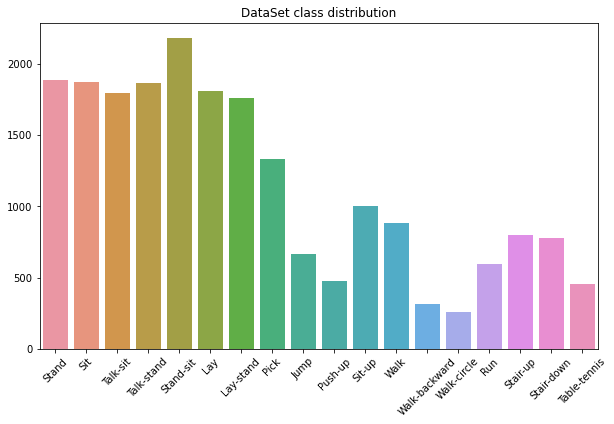

In [10]:
#Plot class distribution
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize = (10,6))
ax = sns.barplot(x=np.vectorize(idx_to_class.get)(unique),
                 y=counts).set_title('DataSet class distribution')
ticks = plt.xticks(rotation=45)

From the above plot we can see that the dataset is imbalanced. To deal with the imbalance, we can either manually split out dataset, or use weights in the model's loss function. Those weights will give priority to the undersampled classes in the computation of the loss. We choose the latter.

We use train_test_split function from sklearn to split between train and test datasets, with 33% of the data being assigned to the test set and 67% to the train set. By setting stratify to y, we make sure that train and validation subsets will mimic the class distribution of the original dataset.

In [11]:
#Creating the training and validation set
features_train, features_test, labels_train, labels_test = sk.model_selection.train_test_split(X, y,
                                                                            test_size = 0.33,
                                                                            shuffle = True,
                                                                            random_state = 69,
                                                                            stratify=y)

In [12]:
n_samples, n_samples_test, n_timesteps, n_features, n_outputs = features_train.shape[0], features_test.shape[0], features_train.shape[1], features_train.shape[2], labels_train.shape[1]

print("----INFO----")
print('samples in the train set: ', n_samples)
print('samples in the test set: ', n_samples_test)
print('timesteps: ', n_timesteps)
print('features: ', n_features)
print('outputs: ',n_outputs)

print("\n----SIZES----")
print('train features input: ', features_train.shape)
print('train labels input: ', labels_train.shape)
print('test features input: ', features_test.shape)
print('test labels input: ', labels_test.shape)

----INFO----
samples in the train set:  13901
samples in the test set:  6848
timesteps:  300
features:  6
outputs:  18

----SIZES----
train features input:  (13901, 300, 6)
train labels input:  (13901, 18)
test features input:  (6848, 300, 6)
test labels input:  (6848, 18)


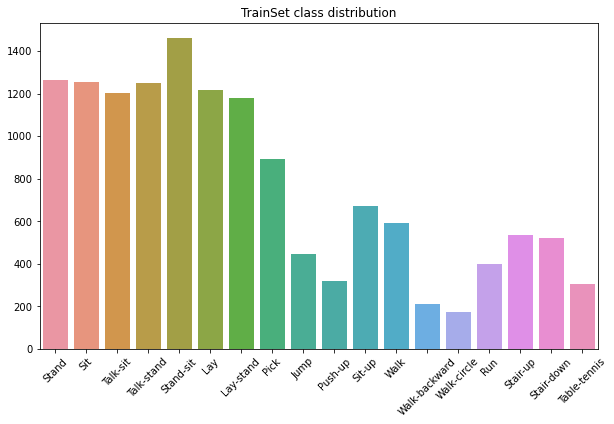

In [13]:
#Plot class distribution in train dataset
train_label_array = np.argmax(labels_train, axis=1)
unique, counts = np.unique(train_label_array, return_counts=True)

plt.figure(figsize = (10,6))
ax = sns.barplot(x=np.vectorize(idx_to_class.get)(unique),
                 y=counts).set_title('TrainSet class distribution')
ticks = plt.xticks(rotation=45)

As expected, the plot above shows that the class distribution of the train set mimics the imbalance of the class distribution of the full dataset.

We then use sklearn function compute_class_weight to compute the weights of each class to balance our train dataset. We create a dictionary of class to weight, which will be used to feed the loss function of our model.

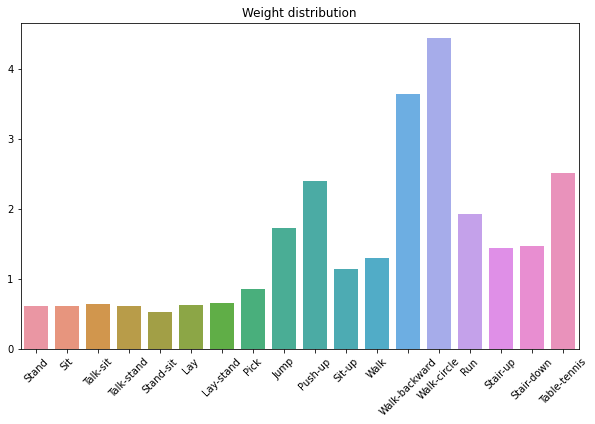

In [14]:
#Compute class weights with sklearn method
class_labels = np.unique(train_label_array)
class_weights = sk.utils.class_weight.compute_class_weight(class_weight='balanced',
                                     classes=class_labels,
                                     y=train_label_array)
class_weights_dict = dict(zip(class_labels, class_weights))

#Plot weights vs class
plt.figure(figsize=(10,6))
ax = sns.barplot(x=np.vectorize(idx_to_class.get)(unique), y=class_weights).set_title("Weight distribution")
ticks = plt.xticks(rotation=45)

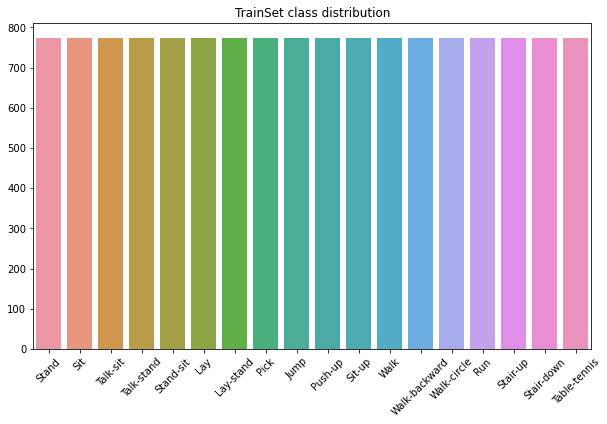

In [15]:
#plot class distribution in train dataset multiplied by the weights
train_label_array = np.argmax(labels_train, axis=1)
unique, counts = np.unique(train_label_array, return_counts=True)
counts = counts * class_weights
plt.figure(figsize = (10,6))
ax = sns.barplot(x=np.vectorize(idx_to_class.get)(unique),
                 y=counts).set_title('TrainSet class distribution')
ticks = plt.xticks(rotation=45)

From the plots above, we can see that the weights actually balance the classes. Thus, by feeding the loss function with the weight input, we expect out model to be able to predict all the classes with accuracy.

## <em>Construct Model</em>

With the data prepared we are able to start building the actual model. As mentioned in the introduction there are mutliple options that seem potent to tackle the problem. In this exercise we have chosen the convolution neural net as our tool. <br>
<br>
<strong> 1st iteration </strong> <br>
We started with 2 convolutional layers that both had 64 filters, with the goal to find patterns in the data. We chose two layers because this would give more depth to the model, allowing the model to have a more efficient learning process. These two layers where followed by a maxpooling layer and flattening layer to reduce the complexity of the layer before feeding it to the standard feedforward part of the net. The feedforward part of the model consisted of a dense layer with 100 layers and the output layer of 18 neurons using the softmax activation function. The rest of the net was chosen to have a 'relu' activation function. This model resulted in an accuracy of ~80% on the testing set.<br>

<strong> 2nd iteration </strong> <br>
To improve the model we decided to expand the 2nd convolutional layer to 128 filters, to allow the model to find more patterns. This made the model more accurate but also more slow (~86%). <br>

<strong> 3rd iteration </strong> <br>
To improve the speed of the model we decided to add a max pooling layer in between the convolutional layers. This improved the speed.<br>

<strong> 4th iteration </strong> <br>
In an attempt to further improve the accuracy of the model we added another convolutional layer having 64 filters. <br>
Also we added an extra dense layer to decrease the step size from 100-18 neurons by adding a layer with 50 neurons. This is the final model we used. 

<strong> 5th iteration </strong> <br>
Since we didn't differentiate yet in the kernel size of the Conv1D layer, we tried to differentiate that. Instinctively, it made sense to first use a bigger kernel size and then use the kernel_size=3 in the second Conv1D layer. Therefore, we increased the first kernel_size to 6. This however, did not improve the model.

In [16]:
def create_model(n_timesteps, n_features, n_outputs):
    """
    method that constructs a tensorflow 1D CNN model
    """
    model = keras.Sequential([
        kl.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
        kl.MaxPooling1D(pool_size=2),
        kl.Conv1D(filters=64, kernel_size=3, activation='relu'),
        kl.MaxPooling1D(pool_size=2),
        kl.Conv1D(filters=128, kernel_size=3, activation='relu'),
        kl.MaxPooling1D(pool_size=2),
        kl.Flatten(),
        kl.Dense(100, activation='relu'),
        kl.Dense(50, activation='relu'),
        kl.Dense(n_outputs, activation='softmax')
    ])

    model.summary()

    return model

In [17]:
#Boolean to decide if we want to retrain a new model or not
newMod = False

if newMod:
    #Create model using inputs found during the split
    model = create_model(n_timesteps, n_features, n_outputs)
    print("Model Created Successfully!")
else:
    #Load old model
    model = tf.keras.models.load_model('model0-927_bc.h5')
    print("Model Loaded Successfully!")
    model.summary()


Model Loaded Successfully!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 298, 64)           1216      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 149, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 147, 64)           12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 71, 128)           24704     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 35, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)        

In [18]:
if newMod:
    #Adding Early Stopping Callback
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

    #Adding Checkpoint
    check = keras.callbacks.ModelCheckpoint('weightRaw.hdf5', save_best_only=True, monitos='val_loss', mode='min')

    #Adding loss, optimizer and metrics values to the model.
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

    #Start Training
    model_training_history = model.fit(x=features_train,
                                       y=labels_train, 
                                       epochs=150, 
                                       batch_size=64, 
                                       shuffle=True, 
                                       validation_split=0.2,
                                       class_weight = class_weights_dict,
                                       callbacks = [check, early_stopping_callback])
    
else:
    print("model is already trained")

model is already trained


### Evaluating model

With the model created we can compare it to previous iterations. We do this by analysing the loss and accuracy of the training set and the validation set, and finally looking at the evaluation of the model on the test set. The metrics used are provided by the evaluation report and the confusion matrix. With them, we can understand in depth where our model performs best and worst. <br>
<em> Disclaimer: </em><br>
In the latest version of this code we added the saving of the training history. Unfortunately we didn't have this feature yet when we found the best model. Therefore we show here the saved .png plots of loss and accuracy, which can ilustrate the behaviour of the training process. This issue is only for the training process - all the variables of the test process (accuracy, report and confusion matrix) are plotted within the code. 

In [19]:
#Get evaluation of model
print('Evaluation current model')
model_evaluation_history = model.evaluate(features_test, labels_test)
model_loss, model_accuracy = model_evaluation_history

if newMod:
    #Load old model
    oldMod = tf.keras.models.load_model('model0-927_bc.h5')
    #Evaluate old model
    print('Evaluation of saved model')
    oldMod_evaluation_history = oldMod.evaluate(features_test, labels_test)
    oldMod_loss, oldMod_accuracy = oldMod_evaluation_history
    #Save new model if it is better than the old model
    if (oldMod_accuracy <= model_accuracy):
        #Save the model
        model.save("best_model.h5")
        #Save its training history
        with open('./trainHistoryDict', 'wb') as file_pi:
            pickle.dump(model_training_history.history, file_pi)
        print("new model saved")
    else:
        print('-------------------------')
        print("previous model was better")

Evaluation current model
214/214 [==============================] - 1s 5ms/step - loss: 0.3683 - accuracy: 0.9274


In [20]:
noSavedTrainingHistory = False
if newMod:
    #Use existing training history
    training_history = model_training_history
else:
    #Get saved training history
    try:
        training_history = pickle.load(open('./trainHistoryDict', "rb"))
    except:
        noSavedTrainingHistory = True

In [21]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
    #Get Metric values using metric names as identifiers
    metric_value_1 = training_history.history[metric_name_1]
    metric_value_2 = training_history.history[metric_name_2]

    #Constructing a range object which will be used as time 
    epochs = range(len(metric_value_1))

    #Plotting the Graph
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    #Adding title to the plot
    plt.title(str(plot_name))

    #Adding legend to the plot
    plt.legend()

In [22]:
if noSavedTrainingHistory != True:
    plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')
    plt.ylim(0,1)

In [23]:
if noSavedTrainingHistory != True:
    plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Loss of the best model (training vs. validation):
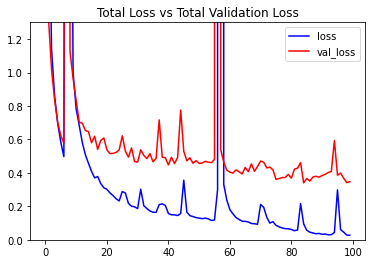

Accuracy of the best model (training vs. validation):
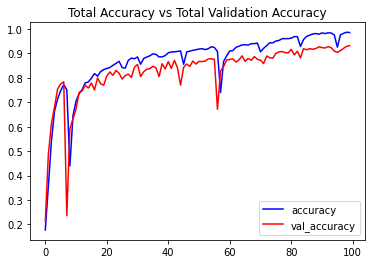

From the plots above we can evaluate if the model is overfitting. In most of the models we didn't find overfitting to be an issue. This is also prevented by the use of the early stop method. <br>
If overfitting would be found we would see that the training loss would start diverging from the validation loss [5]. Also, we would observe a significantly lower performance on the test set relative to the training set. We stop the iterations before this behaviour is observed.

In [24]:
# Convert the prediction result to class name
y_pred = model.predict(features_test)
y_pred_label = np.vectorize(idx_to_class.get)(np.argmax(y_pred, axis=1)) 
y_true_label = np.vectorize(idx_to_class.get)(np.argmax(labels_test, axis=1))

In [25]:
# Print the classification report
print('\nClassification Report:\n', sk.metrics.classification_report(y_true_label,
                                                          y_pred_label))


Classification Report:
                precision    recall  f1-score   support

         Jump       0.96      0.99      0.98       220
          Lay       0.94      0.90      0.92       598
    Lay-stand       0.93      0.95      0.94       582
         Pick       0.91      0.92      0.91       440
      Push-up       0.91      0.97      0.94       158
          Run       0.96      0.96      0.96       196
          Sit       0.90      0.87      0.89       619
       Sit-up       0.96      0.93      0.94       332
   Stair-down       0.95      0.89      0.92       258
     Stair-up       0.90      0.86      0.88       263
        Stand       0.89      0.94      0.91       622
    Stand-sit       0.98      0.97      0.98       719
 Table-tennis       0.92      0.99      0.95       151
     Talk-sit       0.89      0.92      0.91       593
   Talk-stand       0.95      0.94      0.94       616
         Walk       0.91      0.92      0.91       291
Walk-backward       0.95      0.94     

The report above shows that overall the precisions for the classes are all good. The accuracy for jumping, stand-sit and talk-sit where really good whilst walk-circle proved to be the hardest to correctly classify. 

In [26]:
def plot_confusion_matrix(cm, classes):
    
    plt.figure(figsize = (12,12))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

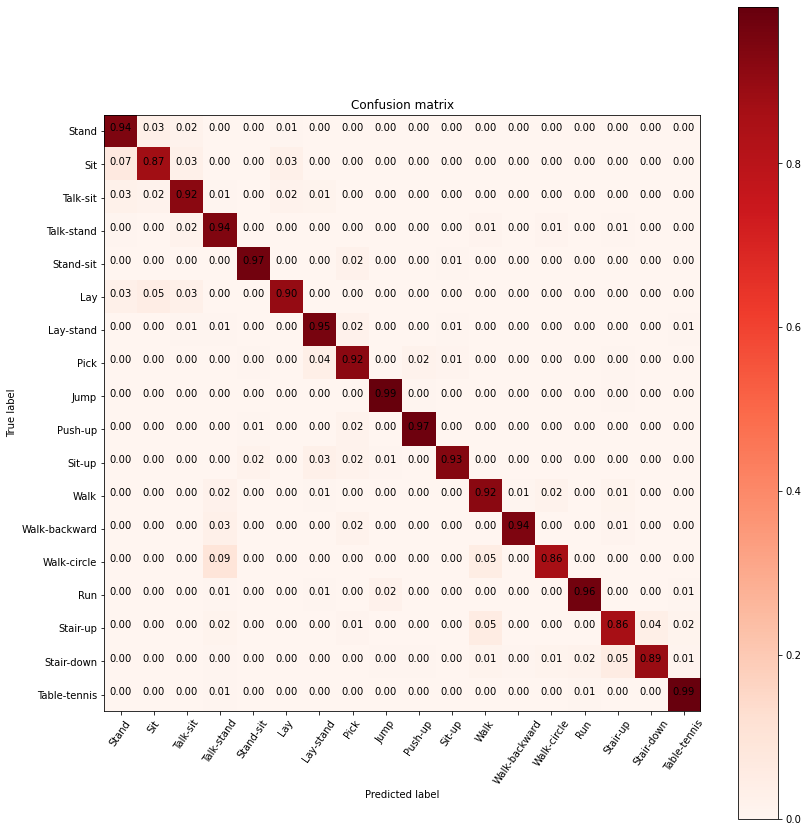

In [27]:
import itertools
# confusion matrix
y_pred_label = np.vectorize(idx_to_class.get)(np.argmax(y_pred, axis=1))
y_true_label = np.vectorize(idx_to_class.get)(np.argmax(labels_test, axis=1))
# Plot the confusion matrix
cm = sk.metrics.confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, label_names)

The confusion matrix above confirms the accuracy of the model. All the classes don't have many false positives. The biggest risk of a wrong recognition would be in Walk-circle that could be recognised as talk-stand. This confusion could be explained because some of the motions would be similar, and the data that we have observe variables that are changing over time (acceleration and angular velocity). Another risk if between sit and stand - which could be seen as opposite motions, therefore having some similarities.

---

### <em> <strong> Reducing the time between predictions </strong> </em>

Since the goal of this project is predicting real-time, in the next session an attempt is made to reduce the time between predictions, i.e., reduce the number of datapoints that we feed the model in order to get a new prediction. The previous model could predict based on 3s of data with an accuracy of 93%. We reduce from 3s of data to 1.5s of data, meaning 150 datapoints.

The strategy used to pre-process the dataset is to split the 3s of each sample into 2 samples of 1.5s. Therefore, we get 2x as many samples as before.

We split the data and calculate weights following the same methodology from the previous sessions. The exact same net is then re-trained with the new data and the model is saved. In the current file, we skip the training process and only load the saved model to show the evaluation results on the test set.

In [28]:
#function to split in 3 parts of 1s of data each
def split_one_second(array_3s):
    array_3s = np.transpose(array_3s, (1, 0))
    array_1s_1, array_1s_2 = np.array_split(array_3s, 2)
    array = np.hstack((array_1s_1, array_1s_2))
    return array

In [29]:
acc_x_1s = split_one_second(acc_x)
acc_y_1s = split_one_second(acc_y)
acc_z_1s = split_one_second(acc_z)
gyro_x_1s = split_one_second(gyro_x)
gyro_y_1s = split_one_second(gyro_y)
gyro_z_1s = split_one_second(gyro_z)

In [31]:
#Combine features into one array, with 3x less datapoints and 3x more samples
feature_array = np.array([acc_x_1s, acc_y_1s, acc_z_1s, gyro_x_1s, gyro_y_1s, gyro_z_1s])
labels = np.tile(labels, 2)
feature_array = np.transpose(feature_array, (2, 1, 0))
print('The feature array has the following shape: {}'.format(feature_array.shape))
print('The label array has the following shape: {}'.format(labels.shape))

The feature array has the following shape: (41498, 150, 6)
The label array has the following shape: (41498,)


In [32]:
# defining dataset for the model
X = feature_array
y = keras.utils.to_categorical(labels)

In [33]:
#Creating the training and validation set
features_train, features_test, labels_train, labels_test = sk.model_selection.train_test_split(X, y,
                                                                            test_size = 0.33,
                                                                            shuffle = True,
                                                                            random_state = 42,
                                                                            stratify=y)

In [34]:
n_samples, n_samples_test, n_timesteps, n_features, n_outputs = features_train.shape[0], features_test.shape[0], features_train.shape[1], features_train.shape[2], labels_train.shape[1]

print("----INFO----")
print('samples in the train set: ', n_samples)
print('samples in the test set: ', n_samples_test)
print('timesteps: ', n_timesteps)
print('features: ', n_features)
print('outputs: ',n_outputs)

print("\n----SIZES----")
print('train features input: ', features_train.shape)
print('train labels input: ', labels_train.shape)
print('test features input: ', features_test.shape)
print('test labels input: ', labels_test.shape)

----INFO----
samples in the train set:  27803
samples in the test set:  13695
timesteps:  150
features:  6
outputs:  18

----SIZES----
train features input:  (27803, 150, 6)
train labels input:  (27803, 18)
test features input:  (13695, 150, 6)
test labels input:  (13695, 18)


In [35]:
#Compute class weights with sklearn method
class_labels = np.unique(train_label_array)
class_weights = sk.utils.class_weight.compute_class_weight(class_weight='balanced',
                                     classes=class_labels,
                                     y=train_label_array)
class_weights_dict = dict(zip(class_labels, class_weights))

In [36]:
#Load trained model
model = tf.keras.models.load_model('model0-836_1s.h5')
print("Model Loaded Successfully!")
model.summary()

Model Loaded Successfully!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 148, 64)           1216      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 128)           24704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
flatten (Flatten)            

In [37]:
#Get evaluation of model
print('Evaluation current model')
model_evaluation_history = model.evaluate(features_test, labels_test)

Evaluation current model
428/428 [==============================] - 1s 3ms/step - loss: 0.3991 - accuracy: 0.8692


In [38]:
# Convert the prediction result to class name
y_pred = model.predict(features_test)
y_pred_label = np.vectorize(idx_to_class.get)(np.argmax(y_pred, axis=1)) 
y_true_label = np.vectorize(idx_to_class.get)(np.argmax(labels_test, axis=1))

In [39]:
# Print the classification report
print('\nClassification Report:\n', sk.metrics.classification_report(y_true_label,
                                                          y_pred_label))


Classification Report:
                precision    recall  f1-score   support

         Jump       0.99      0.99      0.99       440
          Lay       0.68      0.85      0.75      1197
    Lay-stand       0.92      0.94      0.93      1163
         Pick       0.96      0.91      0.93       880
      Push-up       0.92      0.96      0.94       317
          Run       0.95      0.98      0.97       393
          Sit       0.75      0.53      0.62      1237
       Sit-up       0.95      0.94      0.94       663
   Stair-down       0.94      0.91      0.93       515
     Stair-up       0.91      0.94      0.92       527
        Stand       0.66      0.76      0.71      1244
    Stand-sit       0.97      0.97      0.97      1437
 Table-tennis       0.97      0.94      0.95       302
     Talk-sit       0.89      0.79      0.84      1186
   Talk-stand       0.93      0.94      0.94      1232
         Walk       0.95      0.95      0.95       582
Walk-backward       0.97      0.92     

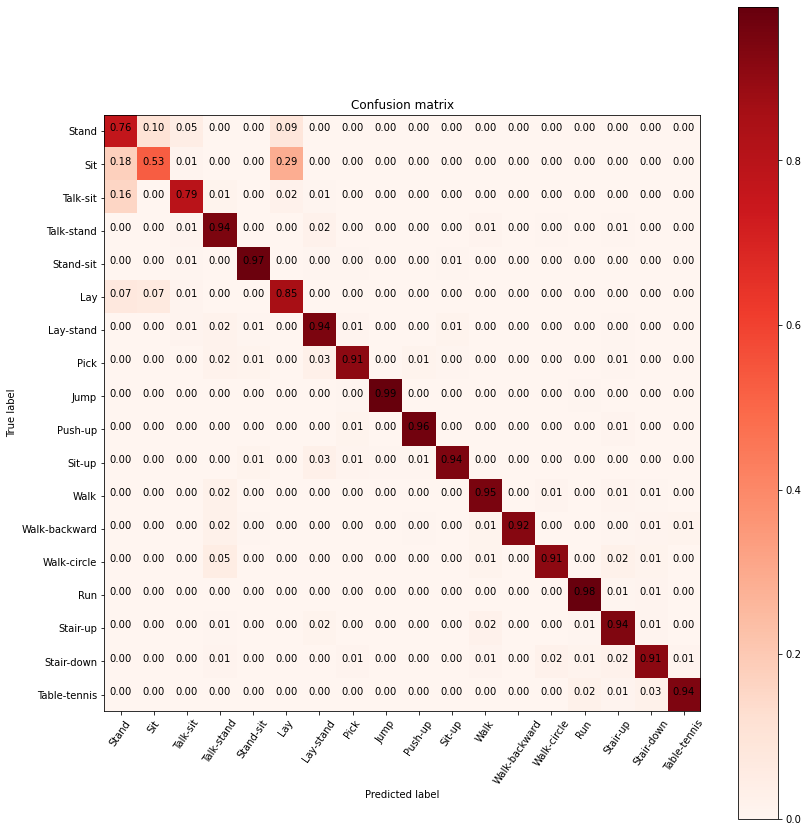

In [41]:
# confusion matrix
y_pred_label = np.vectorize(idx_to_class.get)(np.argmax(y_pred, axis=1))
y_true_label = np.vectorize(idx_to_class.get)(np.argmax(labels_test, axis=1))
# Plot the confusion matrix
cm = sk.metrics.confusion_matrix(np.argmax(labels_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, label_names)

We observe an accuracy of 87% - it is also worth mentioning that the training process took only 48 epochs to reach that result.

From the report we can see that stand, sit and talk-sit were the most affected by the reduction in the performance of the model. Sit had already presented a lower performance tha average on the previous model, but stand and talk-sit had very good results. It is possible that those movements require more timestamps of data to provide a good prediction.

Overall, the model tends to predict very few 'sit', while it predicts 'stand' and 'lay' for many cases when the true label is a different one.

## <em> <strong> Conclusion </strong> </em>

The model created based on 3s of data performs well, having an accuracy of 93%. This accuracy ranges from 85%-98% across the classes, where some classes probably have more unique features and therefore can be better predicted, while other motions have quite similar patterns. This also means that this model is more accurate than the Random Forest model and the first CNN model found in literature ([3] and [4]). The second CNN model (97%) proved to be better than this one, but it uses a whole different approach, with circular matrices and 2D convolutional layers. We tried this approach with no success due to the huge memory required to work with such matrices. <br>

With this model we would be able to early recognise the trained movements when we input them into the model, giving an updated prediction every 3s of data. We consider this near real-time and good enough for many applications, since most sensors do have a delay before starting to give feedback to the user. The same model, trained on 1.5s of data, provided a fairly good accuracy of 87%. Some labels were clearly more affected than other by the reduction of the number of datapoints.

## <strong> <em> References </em> </strong>

[1] https://data.mendeley.com/datasets/45f952y38r/5
   
[2] https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

[3] https://doi.org/10.1016/j.patrec.2021.02.024

[4] 10.1109/ICIEVicIVPR52578.2021.9564234

[5] https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5